# 딥러닝 파이프라인을 처음부터 끝까지 구현해보기

## 데이터셋

### MNIST 데이터셋

![MNIST Example](https://upload.wikimedia.org/wikipedia/commons/f/f7/MnistExamplesModified.png)

- MNIST 데이터셋은 미국의 NIST에서 이미지 처리 시스템을 위해 모은 손글씨 이미지 데이터셋 NIST Special Database 3 중 일부를 재구성한 것
- 0부터 9까지의 숫자 이미지와 이에 대응되는 숫자가 한 쌍으로 구성
- 이 데이터셋은 머신러닝 및 딥러닝 분야에서 가장 잘 알려진 벤치마크 데이터셋 중 하나
- 특히 딥러닝 기초 관련 교보재에 주로 활용
- 데이터셋 구성
    - 입력(이미지): 0부터 9까지의 숫자 중 하나에 속하는 28px * 28px의 흑백 이미지
    - 출력(숫자): 주어진 이미지에 대응되는 숫자 (0~9)
- 데이터 샘플 수
    - 학습 데이터: 60,000 개
    - 테스트 데이터: 10,000 개
- 데이터셋 저작권: [CC BY-SA 3.0](https://creativecommons.org/licenses/by-sa/3.0/)

In [1]:
import random

import numpy as np


# 재현성을 위한 시드 고정
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

### MNIST 데이터셋 다운로드 및 가져오기

In [2]:
from pathlib import Path


DATASET_DIR = Path("./data/MNIST")  # 다운받을 data directory 먼저 초기화
DATASET_DIR.mkdir(parents=True, exist_ok=True)

In [3]:
URL_MNIST = "https://ossci-datasets.s3.amazonaws.com/mnist/"

KEY_FILES = {
    "train_img": "train-images-idx3-ubyte.gz",
    "train_label": "train-labels-idx1-ubyte.gz",
    "test_img": "t10k-images-idx3-ubyte.gz",
    "test_label": "t10k-labels-idx1-ubyte.gz",
}

In [4]:
# 해당 경로에 파일 없는 경우에 다운로드 하도록함
from urllib.request import urlretrieve


filelist = DATASET_DIR.glob("*")

for filename in KEY_FILES.values():
    if filename not in filelist:
        filepath = DATASET_DIR / filename
        urlretrieve(URL_MNIST + filename, filepath)
        print("Downloaded", filename, "to", filepath)

Downloaded train-images-idx3-ubyte.gz to data/MNIST/train-images-idx3-ubyte.gz
Downloaded train-labels-idx1-ubyte.gz to data/MNIST/train-labels-idx1-ubyte.gz
Downloaded t10k-images-idx3-ubyte.gz to data/MNIST/t10k-images-idx3-ubyte.gz
Downloaded t10k-labels-idx1-ubyte.gz to data/MNIST/t10k-labels-idx1-ubyte.gz


### MNIST 데이터셋 전처리

In [5]:
import gzip

import numpy as np


def convert_img_to_ndarray(img_zip_path: Path) -> np.ndarray[np.ndarray[np.float32]]:
    with gzip.open(img_zip_path) as f:
        # buffer: 버퍼 객체(여기서는 f.read())
        # dtype: 데이터 타입(여기서는 "B", unsigned byte를 의미, np.uint8과 동일)
        # offset: 시작 위치를 지정하는 byte offset(여기서는 매직 넘버(16))
        #         첫 16 byte 는 n_imgs, n_rows, n_cols 의 정보이므로 무시
        pixels = np.frombuffer(f.read(), "B", offset=16)

    # (채널 수, 1차원이 된 이미지 데이터) MNIST 는 흑백이므로 채널 수는 1
    return pixels.reshape(-1, 28 * 28).astype(np.float32) / 255.0  # 0 ~ 1 사이로 정규화

In [6]:
# 학습 및 테스트 이미지를 numpy 행렬로 변환 및 정규화 전처리 진행
x_train = convert_img_to_ndarray(DATASET_DIR / KEY_FILES["train_img"])
x_test = convert_img_to_ndarray(DATASET_DIR / KEY_FILES["test_img"])

In [7]:
def encoding_as_onehot(int_labels: np.ndarray[np.int8]) -> np.ndarray[np.ndarray[np.int8]]:
    # 입력 값 예시:
    # [7, 2, 1, 0, 4, ...] (각 샘플의 클래스 인덱스)
    num_rows = len(int_labels)
    num_cols = int_labels.max() + 1

    onehot = np.zeros((num_rows, num_cols), dtype=np.uint8)
    onehot[np.arange(num_rows), int_labels] = 1

    # 출력 값 예시:
    # [[0 0 0 0 0 0 0 1 0 0]  # 7
    # [0 0 1 0 0 0 0 0 0 0]  # 2
    # [0 1 0 0 0 0 0 0 0 0]  # 1
    # [1 0 0 0 0 0 0 0 0 0]  # 0
    # [0 0 0 0 1 0 0 0 0 0]  # 4
    # ...]
    return onehot


def convert_label_gz_to_ndarray(label_zip_path: Path) -> np.ndarray[np.ndarray[np.int8]]:
    with gzip.open(label_zip_path) as f:
        labels = np.frombuffer(f.read(), "B", offset=8)
    return encoding_as_onehot(labels)

In [8]:
# 학습 및 테스트 라벨을 numpy 행렬로 변환 및 전처리
y_train = convert_label_gz_to_ndarray(DATASET_DIR / KEY_FILES["train_label"])
y_test = convert_label_gz_to_ndarray(DATASET_DIR / KEY_FILES["test_label"])

In [9]:
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

x_train shape: (60000, 784)
y_train shape: (60000, 10)
x_test shape: (10000, 784)
y_test shape: (10000, 10)


### MNIST 샘플 살펴보기

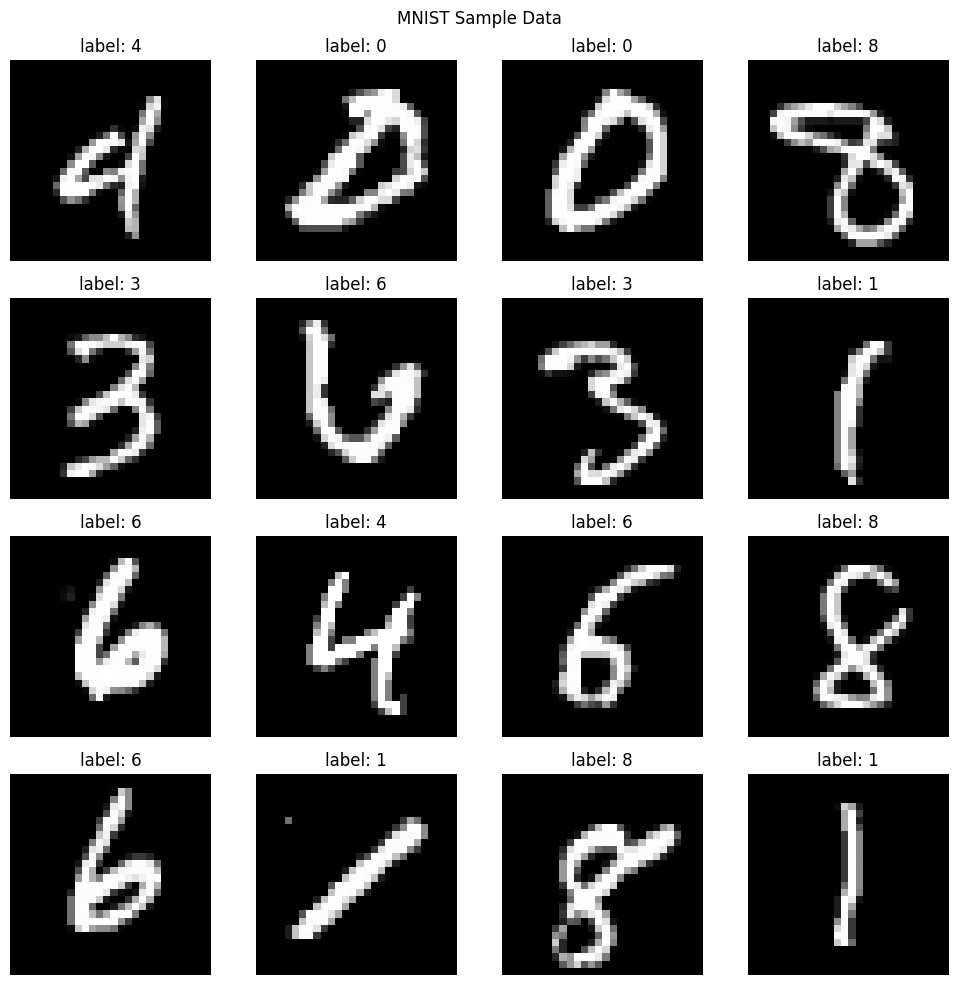

In [10]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 10))

# 랜덤한 16개의 index
indices = np.random.randint(0, len(x_train), size=16)
for n, idx in enumerate(indices, start=1):
    plt.subplot(4, 4, n)
    plt.imshow(x_train[idx].reshape(28, 28), cmap="gray")
    plt.title(f"label: {y_train[idx].argmax()}")
    plt.axis("off")

plt.suptitle("MNIST Sample Data")
plt.tight_layout()
plt.show()

## 다층 퍼셉트론(Multi-Layer Perceptron, MLP)

![MNIST MLP](../docs/img/20250619/simple_mnist_mlp.png)

### 활성화 함수 구현

- sigmoid

$$
\sigma(x) = \frac{1}{1 + e^{-x}}
$$

- sigmoid 의 미분 공식

$$
\frac{d\sigma(x)}{dx} = \sigma(x) \cdot (1 - \sigma(x))
$$

In [11]:
# 위 수식을 python 함수로 표현하면 아래와 같음


def sigmoid(x: np.ndarray) -> np.ndarray:
    return 1.0 / (1.0 + np.exp(-x))


def sigmoid_prime(x: np.ndarray) -> np.ndarray:
    return (1.0 - sigmoid(x)) * sigmoid(x)

### sigmoid layer 구현

- 순전파의 계산 그래프

![순전파 계산 그래프](../docs/img/20250619/computational_graph_forward.png)

- 역전파의 계산 그래프

![역전파 계산 그래프](../docs/img/20250619/computational_graph_backward.png)

In [12]:
class SigmoidLayer:
    def __init__(self):
        self.out: np.ndarray | None = None

    def forward(self, x: np.ndarray) -> np.ndarray:
        self.out = 1.0 / (1.0 + np.exp(-x))
        return self.out

    def backward(self, dout: np.ndarray) -> np.ndarray:
        return dout * (1.0 - self.out) * self.out  # dx

- SigmoidLayer 테스트
    - 임의의 사이즈에 대해 모두 동일한 크기의 결과가 출력되어야 하며, 각각 단순하게 시그모이드 함수를 적용한 값과 도함수를 적용한 값이 된다면 성공

In [13]:
x_input = np.random.randn(5, 2)  # 표준 정규 분포에서 (5, 2) 형태를 반환
x_input

array([[-0.46947439,  0.54256004],
       [-0.46341769, -0.46572975],
       [ 0.24196227, -1.91328024],
       [-1.72491783, -0.56228753],
       [-1.01283112,  0.31424733]])

In [14]:
sigmoid_layer = SigmoidLayer()
sigmoid_layer.forward(x_input)

array([[0.38474066, 0.63240775],
       [0.38617537, 0.38562745],
       [0.56019716, 0.12861278],
       [0.1512388 , 0.36301833],
       [0.26642616, 0.57792165]])

In [15]:
# 최종 출력물의 미분값이 1일 경우 역전파의 결과
sigmoid_layer.backward(1)

array([[0.23671528, 0.23246819],
       [0.23704395, 0.23691892],
       [0.2463763 , 0.11207153],
       [0.12836563, 0.23123602],
       [0.19544326, 0.24392822]])

### MLP Layer 구현

- Fully Connected Layer 를 구현

In [16]:
class FCLayer:
    def __init__(self, input_size: int | float, output_size: int | float):
        """
        :param input_size: 입력 데이터의 차원 수
        :param output_size: 출력 데이터의 차원 수
        """

        # 가중치는 정규 분포를 따르는 난수로 초기화
        self.w = np.random.randn(input_size, output_size)
        # 편향 역시 정규 분포를 따르는 난수로 초기화
        self.b = np.random.randn(output_size)

        self.x: np.ndarray | None = None  # 역전파 계산을 위해 입력 데이터 저장

        # 모델 학습을 위해 저장할 데이터
        self.dw: np.ndarray | None = None  # 가중치의 그래디언트
        self.db: np.ndarray | None = None  # 편향의 그래디언트

    def forward(self, x: np.ndarray) -> np.ndarray:
        self.x = x
        return np.dot(self.x, self.w) + self.b

    def backward(self, dout: np.ndarray) -> np.ndarray:
        # 여기서 dL/dy 는 출력에 대한 손실 함수의 그래디언트로, dout 이 이에 해당

        # 학습시에 self.w 와 self.b 의 값을 변경할 때, self.dw 와 self.db 를 사용함
        # w = w - learning_rate * dw
        # b = b - learning_rate * db

        # dw = dL/dw = dL/dy · dy/dw = dout · x^T
        self.dw = np.dot(self.x.T, dout)
        # db = dL/db = dL/dy · dy/db = dout · 1 = dout
        self.db = np.sum(dout, axis=0)  # 이는 dout 을 배치 차원(axis=0)에 대해 합산한 것

        # dx = dL/dx = dL/dy · dy/dx = dout · w^T
        return np.dot(dout, self.w.T)

- FCLayer 테스트

In [17]:
# batch size 가 5
input_x = np.random.randn(5, 2)  # 표준 정규 분포를 따르는 (5, 2) 형태의 ndarray
print("input_x:")
print(input_x)

output_y = np.random.randn(5, 3)  # 표준 정규 분포를 따르는 (5, 3) 형태의 ndarray
print()
print("output_y:")
print(output_y)

input_x:
[[-0.90802408 -1.4123037 ]
 [ 1.46564877 -0.2257763 ]
 [ 0.0675282  -1.42474819]
 [-0.54438272  0.11092259]
 [-1.15099358  0.37569802]]

output_y:
[[-0.60063869 -0.29169375 -0.60170661]
 [ 1.85227818 -0.01349722 -1.05771093]
 [ 0.82254491 -1.22084365  0.2088636 ]
 [-1.95967012 -1.32818605  0.19686124]
 [ 0.73846658  0.17136828 -0.11564828]]


In [18]:
fc_layer = FCLayer(input_size=2, output_size=3)
print("forward:")
print(fc_layer.forward(input_x))
print()
print("backward:")
print(fc_layer.backward(output_y))

forward:
[[-0.83906891  0.1736399  -0.21673979]
 [-2.1003511  -2.08158311 -1.51770192]
 [-1.12707889 -1.28189094 -0.9232616 ]
 [-1.65021975  1.24622453  0.0449035 ]
 [-1.58953281  2.42301201  0.57255049]]

backward:
[[ 1.04526517 -0.23843588]
 [ 0.22361522 -1.23094818]
 [ 1.40702362 -1.59770768]
 [ 2.41210678 -0.43370983]
 [-0.39247804 -0.19874798]]


### 손실 함수 구현

- Mean Square Error 구현하기
- MSE 수식

$$
L_{MSE}(y,\hat{y}) = \frac{1}{n}\sum_{i=1}^n(y_i - \hat{y}_i)^2
$$

- MSE 미분식

$$
\frac{dL}{d\hat y} = \frac{2}{n}\sum_{i=1}^n \left(\hat{y}_i - y\right)
$$

In [19]:
class MSELoss:
    def __init__(self):
        self.loss: np.ndarray | None = None  # 손실 함수 값. 역전파 계산을 위해서 저장
        self.y: np.ndarray | None = None  # 추론값
        self.t: np.ndarray | None = None  # 실제값(target)

    def forward(self, y: np.ndarray, t: np.ndarray) -> np.ndarray:
        # L = 1 / N * sum((y - t)^2)
        self.y = y
        self.t = t
        self.loss = np.mean((y - t) ** 2)
        return self.loss

    def backward(self, dout=1):
        # MSE를 y에 대해 미분: dL/dy = 2(y - t)/N
        # 연쇄 법칙 적용: dy = dout * dL/dy = dout * 2(y - t)/N
        return dout * (self.y - self.t) * 2 / self.t.shape[0]  # dy

##### backward 부연설명

이 메서드는 손실 함수의 그래디언트를 계산

1. `dout`은 이 계층의 출력(손실 값)에 대한 그래디언트. 일반적으로 최종 출력 계층에서는 1로 설정(기본값)
2. MSE 손실 함수를 예측값 `y`에 대해 미분하면,

$$
\frac{\partial L}{\partial y_i} = \frac{2(y_i - t_i)}{N}
$$

이 공식은 다음과 같이 도출된다.
- MSE

$$
L = \frac{1}{N} \sum_{i=1}^{N} (y_i - t_i)^2
$$


- 미분

$$
\frac{\partial L}{\partial y_i} = \frac{1}{N} \cdot 2(y_i - t_i) = \frac{2(y_i - t_i)}{N}
$$


3. 코드에서 `self.t.shape[0]`는 배치 크기 N을 나타낸다.
4. 최종적으로 계산된 그래디언트 `dx`를 반환하여 이전 계층으로 전파한다.

**연쇄 법칙의 적용**

역전파 메서드에서는 연쇄 법칙이 적용된다.

- `dx = dout * (2(y - t) / N)`

이는 다음 수식을 의미합니다.

$$
\frac{\partial L_{total}}{\partial y} = \frac{\partial L_{total}}{\partial L_{MSE}} \cdot \frac{\partial L_{MSE}}{\partial y} = dout \cdot \frac{2(y - t)}{N}
$$

여기서,
- $\frac{\partial L_{total}}{\partial L_{MSE}}$ 는 `dout`에 해당한다. (일반적으로 1)
- $\frac{\partial L_{MSE}}{\partial y}$ 는 MSE를 y에 대해 미분한 값 $\frac{2(y - t)}{N}$ 이다.

- 교차 엔트로피(Cross Entropy) 구현하기
- 수식

$$
 L(y,\hat{y}) = \frac{-1}{n}\sum_{i=1}^n y_i\log(\hat{y}_i)+(1-y_i)(\log(1-\hat{y}_i)
$$

- 미분식

$$
\frac{dL}{d\hat y} = \frac{-1}{n}\left(\frac{y_i}{\hat{y}_i} - \frac{1-y_i}{1 - \hat{y}_i}\right) = \frac{\hat{y}_i-y_i}{n(1-\hat{y}_i)\hat{y}_i}
$$

In [20]:
class CrossEntropyLoss:
    def __init__(self):
        self.loss: np.ndarray | None = None
        self.y: np.ndarray | None = None
        self.t: np.ndarray | None = None

    def forward(self, y: np.ndarray, t: np.ndarray) -> np.ndarray:
        self.y = y
        self.t = t
        self.loss = -np.sum(t * np.log(y + 1e-7) + (1 - t) * np.log(1 - y + 1e-7)) / y.shape[0]
        return self.loss

    def backward(self, dout=1) -> np.ndarray:
        # dL/dy = -t / y + (1 - t) / (1 - y) = (y - t) / ((1 - y)y)
        return dout * (self.y - self.t) / ((1 - self.y) * self.y + 1e-7) / self.y.shape[0]

### MLP 구현

![MNIST MLP](../docs/img/20250619/simple_mnist_mlp.png)

In [21]:
class MLP:
    def __init__(
        self,
        input_size: int | float,
        hidden_size_list: list[int | float],
        output_size: int | float,
        loss_type: str = "MSE",
    ):
        # 여기서 모델의 구조를 정하는 것
        self.input_size = input_size
        self.hidden_size_list = hidden_size_list
        self.hidden_layer_size = len(self.hidden_size_list)
        self.output_size = output_size
        self.loss_type = loss_type

        # 레이어 쌓기

        # 1. 입력층
        self.layers = [
            FCLayer(self.input_size, self.hidden_size_list[0]),
            SigmoidLayer(),
        ]

        # 2. 은닉층
        for i in range(1, self.hidden_layer_size):
            self.layers.append(FCLayer(self.hidden_size_list[i - 1], self.hidden_size_list[i]))
            self.layers.append(SigmoidLayer())

        # 3. 출력층
        self.layers.append(FCLayer(self.hidden_size_list[-1], self.output_size))
        self.layers.append(SigmoidLayer())

        # 손실 함수 레이어 설정
        if self.loss_type == "MSE":
            self.loss_layer = MSELoss()
        elif self.loss_type == "CrossEntropy":
            self.loss_layer = CrossEntropyLoss()

        self.loss: np.ndarray | None = None

    def predict(self, x: np.ndarray) -> np.ndarray:
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def forward(self, x: np.ndarray, t: np.ndarray) -> np.ndarray:
        y = self.predict(x)
        self.loss = self.loss_layer.forward(y, t)
        return self.loss

    def backward(self, dout=1) -> np.ndarray:
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

- MLP 모델 테스트하기

In [22]:
input_x = np.random.randn(5, 2)
input_y = np.random.randn(5, 1)

mlp = MLP(input_size=2, hidden_size_list=[10, 5], output_size=1, loss_type="MSE")
print("predict:")
print(mlp.predict(input_x))
print("forward:")
print(mlp.forward(input_x, input_y))
print("backward:")
print(mlp.backward())

predict:
[[0.61866577]
 [0.67589295]
 [0.68764321]
 [0.6461187 ]
 [0.69268993]]
forward:
1.5170037025138228
backward:
[[ 0.02611226 -0.03983601]
 [ 0.02674919 -0.06219475]
 [-0.00143814  0.00437836]
 [-0.0115444   0.01842142]
 [ 0.0189616  -0.02745467]]


## 모델 학습하기

### 정확도 함수 구현

In [23]:
def accuracy(preds: np.ndarray, target: np.ndarray) -> float:
    # one-hot 인코딩이 되어 있는 값을 다시 라벨로 바꾸어 비교
    y = np.argmax(preds, axis=1)
    t = np.argmax(target, axis=1)
    return np.sum(t == y) / float(t.shape[0])

### 하이퍼파라미터 설정

**학습률 설정**

- MSE 손실 함수는 vanishing gradient 문제가 생길 수 있으므로 **CE 의 학습률보다 더 큰 값의 학습률을 설정**해주었다.
- 즉, 이전 강의에서 살펴본 바와 같이, 동일한 학습률을 사용한다면 CE의 학습이 MSE보다 훨씬 빠를 것이다.
- MNIST 데이터셋의 경우 학습이 쉬운 데이터셋이기에 본 실습에서는 빠른 학습을 위해 큰 값으로 정하였으나,
- 일반적으로 학습률은 소수점 단위(0.01 ~ 0.000001)로 설정되는 매우 작은 값이다.

In [24]:
# 네트워크 구조를 정하기 위한 하이퍼파라미터(784 > 64 -> 16 -> 10)
n_input = 784
n_hidden = (
    64,
    16,
)
n_output = 10

# 학습에 필요한 하이퍼파라미터
batch_size = 128
n_epochs = 30
print_every = 1
learning_rate_mse = 3
learning_rate_ce = 0.5

### 모델 생성

In [25]:
mlp_w_mse = MLP(n_input, n_hidden, n_output, loss_type="MSE")
mlp_w_ce = MLP(n_input, n_hidden, n_output, loss_type="CrossEntropy")

### 학습 구현

In [26]:
from tqdm import tqdm


def train(
    model: MLP,
    learning_rate: float,
    data: tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray],
) -> np.ndarray:
    total_train_x, total_train_y, total_test_x, total_test_y = data

    training_errors, training_accuracies = [], []
    test_errors, test_accuracies = [], []

    for epoch in tqdm(range(n_epochs)):
        shuffled_idx = np.random.permutation(total_train_x.shape[0])
        train_x = total_train_x[shuffled_idx]
        train_y = total_train_y[shuffled_idx]

        for i in range(0, total_train_x.shape[0], batch_size):
            batch_x = train_x[i : i + batch_size]
            batch_y = train_y[i : i + batch_size]

            # 순전파
            model.forward(batch_x, batch_y)

            # 역전파
            model.backward()

            # 모델의 파라미터 업데이트
            for layer in model.layers:
                if isinstance(layer, FCLayer):
                    layer.w = layer.w - learning_rate * layer.dw
                    layer.b = layer.b - learning_rate * layer.db
        # 학습 과정 출력
        if (epoch + 1) % print_every == 0:
            # 모든 학습 데이터에 대한 손실과 정확도 계산
            model.forward(train_x, train_y)
            training_errors.append(model.loss)
            training_accuracies.append(accuracy(model.predict(train_x), train_y))

            model.forward(total_test_x, total_test_y)
            test_errors.append(model.loss)
            test_accuracies.append(accuracy(model.predict(total_test_x), total_test_y))

            print(
                f"[Epoch {epoch + 1}/{n_epochs}]",
                f"Train loss: {training_errors[-1]:.3f}",
                "|",
                f"Train accuracy: {training_accuracies[-1] * 100:.3f}",
                "|",
                f"Test loss: {test_errors[-1]:.3f}",
                "|",
                f"Test accuracy: {test_accuracies[-1] * 100:.3f}",
            )
    return np.asarray([training_errors, training_accuracies, test_errors, test_accuracies])

In [27]:
dataset = (x_train, y_train, x_test, y_test)

In [28]:
# MSE 손실 함수를 사용하는 모델로 학습
mse_result = train(mlp_w_mse, learning_rate_mse, data=dataset)

  3%|▎         | 1/30 [00:00<00:11,  2.49it/s]

[Epoch 1/30] Train loss: 0.030 | Train accuracy: 81.652 | Test loss: 0.030 | Test accuracy: 81.960


  7%|▋         | 2/30 [00:00<00:10,  2.68it/s]

[Epoch 2/30] Train loss: 0.019 | Train accuracy: 88.333 | Test loss: 0.019 | Test accuracy: 87.820


 10%|█         | 3/30 [00:01<00:10,  2.64it/s]

[Epoch 3/30] Train loss: 0.016 | Train accuracy: 90.082 | Test loss: 0.017 | Test accuracy: 89.750


 13%|█▎        | 4/30 [00:01<00:09,  2.63it/s]

[Epoch 4/30] Train loss: 0.013 | Train accuracy: 91.955 | Test loss: 0.014 | Test accuracy: 90.950


 17%|█▋        | 5/30 [00:01<00:09,  2.62it/s]

[Epoch 5/30] Train loss: 0.012 | Train accuracy: 92.772 | Test loss: 0.013 | Test accuracy: 91.960


 20%|██        | 6/30 [00:02<00:09,  2.65it/s]

[Epoch 6/30] Train loss: 0.011 | Train accuracy: 93.397 | Test loss: 0.012 | Test accuracy: 92.260


 23%|██▎       | 7/30 [00:02<00:08,  2.66it/s]

[Epoch 7/30] Train loss: 0.010 | Train accuracy: 93.700 | Test loss: 0.012 | Test accuracy: 92.500


 27%|██▋       | 8/30 [00:03<00:08,  2.66it/s]

[Epoch 8/30] Train loss: 0.010 | Train accuracy: 94.052 | Test loss: 0.012 | Test accuracy: 92.540


 30%|███       | 9/30 [00:03<00:07,  2.64it/s]

[Epoch 9/30] Train loss: 0.009 | Train accuracy: 94.655 | Test loss: 0.011 | Test accuracy: 93.020


 33%|███▎      | 10/30 [00:03<00:07,  2.66it/s]

[Epoch 10/30] Train loss: 0.009 | Train accuracy: 94.773 | Test loss: 0.011 | Test accuracy: 93.340


 37%|███▋      | 11/30 [00:04<00:07,  2.67it/s]

[Epoch 11/30] Train loss: 0.008 | Train accuracy: 95.238 | Test loss: 0.010 | Test accuracy: 93.390


 40%|████      | 12/30 [00:04<00:06,  2.66it/s]

[Epoch 12/30] Train loss: 0.008 | Train accuracy: 95.195 | Test loss: 0.010 | Test accuracy: 93.700


 43%|████▎     | 13/30 [00:04<00:06,  2.65it/s]

[Epoch 13/30] Train loss: 0.007 | Train accuracy: 95.680 | Test loss: 0.010 | Test accuracy: 93.990


 47%|████▋     | 14/30 [00:05<00:05,  2.71it/s]

[Epoch 14/30] Train loss: 0.007 | Train accuracy: 95.622 | Test loss: 0.010 | Test accuracy: 93.710


 50%|█████     | 15/30 [00:05<00:05,  2.73it/s]

[Epoch 15/30] Train loss: 0.007 | Train accuracy: 96.050 | Test loss: 0.009 | Test accuracy: 94.110


 53%|█████▎    | 16/30 [00:06<00:05,  2.69it/s]

[Epoch 16/30] Train loss: 0.007 | Train accuracy: 96.087 | Test loss: 0.009 | Test accuracy: 94.140


 57%|█████▋    | 17/30 [00:06<00:04,  2.65it/s]

[Epoch 17/30] Train loss: 0.006 | Train accuracy: 96.145 | Test loss: 0.009 | Test accuracy: 94.170


 60%|██████    | 18/30 [00:06<00:04,  2.71it/s]

[Epoch 18/30] Train loss: 0.006 | Train accuracy: 96.337 | Test loss: 0.009 | Test accuracy: 94.140


 63%|██████▎   | 19/30 [00:07<00:04,  2.71it/s]

[Epoch 19/30] Train loss: 0.006 | Train accuracy: 96.568 | Test loss: 0.009 | Test accuracy: 94.440


 67%|██████▋   | 20/30 [00:07<00:03,  2.74it/s]

[Epoch 20/30] Train loss: 0.006 | Train accuracy: 96.742 | Test loss: 0.009 | Test accuracy: 94.460


 70%|███████   | 21/30 [00:07<00:03,  2.74it/s]

[Epoch 21/30] Train loss: 0.006 | Train accuracy: 96.772 | Test loss: 0.009 | Test accuracy: 94.530


 73%|███████▎  | 22/30 [00:08<00:02,  2.73it/s]

[Epoch 22/30] Train loss: 0.005 | Train accuracy: 96.922 | Test loss: 0.009 | Test accuracy: 94.280


 77%|███████▋  | 23/30 [00:08<00:02,  2.69it/s]

[Epoch 23/30] Train loss: 0.005 | Train accuracy: 96.968 | Test loss: 0.009 | Test accuracy: 94.460


 80%|████████  | 24/30 [00:08<00:02,  2.65it/s]

[Epoch 24/30] Train loss: 0.007 | Train accuracy: 96.112 | Test loss: 0.010 | Test accuracy: 93.900


 83%|████████▎ | 25/30 [00:09<00:01,  2.63it/s]

[Epoch 25/30] Train loss: 0.005 | Train accuracy: 97.215 | Test loss: 0.008 | Test accuracy: 94.870


 87%|████████▋ | 26/30 [00:09<00:01,  2.67it/s]

[Epoch 26/30] Train loss: 0.005 | Train accuracy: 97.323 | Test loss: 0.008 | Test accuracy: 94.770


 90%|█████████ | 27/30 [00:10<00:01,  2.69it/s]

[Epoch 27/30] Train loss: 0.005 | Train accuracy: 97.358 | Test loss: 0.008 | Test accuracy: 94.850


 93%|█████████▎| 28/30 [00:10<00:00,  2.71it/s]

[Epoch 28/30] Train loss: 0.005 | Train accuracy: 97.382 | Test loss: 0.008 | Test accuracy: 94.840


 97%|█████████▋| 29/30 [00:10<00:00,  2.67it/s]

[Epoch 29/30] Train loss: 0.004 | Train accuracy: 97.463 | Test loss: 0.008 | Test accuracy: 94.870


100%|██████████| 30/30 [00:11<00:00,  2.67it/s]

[Epoch 30/30] Train loss: 0.004 | Train accuracy: 97.515 | Test loss: 0.008 | Test accuracy: 94.910


In [29]:
# Cross Entropy 손실 함수를 사용하는 모델로 학습
ce_result = train(mlp_w_ce, learning_rate_ce, data=dataset)

  3%|▎         | 1/30 [00:00<00:11,  2.55it/s]

[Epoch 1/30] Train loss: 1.456 | Train accuracy: 74.253 | Test loss: 1.436 | Test accuracy: 74.730


  7%|▋         | 2/30 [00:00<00:10,  2.69it/s]

[Epoch 2/30] Train loss: 0.995 | Train accuracy: 84.170 | Test loss: 0.985 | Test accuracy: 84.350


 10%|█         | 3/30 [00:01<00:10,  2.59it/s]

[Epoch 3/30] Train loss: 0.797 | Train accuracy: 87.545 | Test loss: 0.796 | Test accuracy: 87.910


 13%|█▎        | 4/30 [00:01<00:09,  2.64it/s]

[Epoch 4/30] Train loss: 0.689 | Train accuracy: 89.333 | Test loss: 0.697 | Test accuracy: 89.180


 17%|█▋        | 5/30 [00:01<00:09,  2.68it/s]

[Epoch 5/30] Train loss: 0.605 | Train accuracy: 90.613 | Test loss: 0.622 | Test accuracy: 90.220


 20%|██        | 6/30 [00:02<00:08,  2.71it/s]

[Epoch 6/30] Train loss: 0.566 | Train accuracy: 91.327 | Test loss: 0.591 | Test accuracy: 90.890


 23%|██▎       | 7/30 [00:02<00:08,  2.69it/s]

[Epoch 7/30] Train loss: 0.513 | Train accuracy: 92.135 | Test loss: 0.550 | Test accuracy: 91.530


 27%|██▋       | 8/30 [00:03<00:08,  2.65it/s]

[Epoch 8/30] Train loss: 0.478 | Train accuracy: 92.673 | Test loss: 0.521 | Test accuracy: 91.930


 30%|███       | 9/30 [00:03<00:07,  2.67it/s]

[Epoch 9/30] Train loss: 0.455 | Train accuracy: 93.013 | Test loss: 0.506 | Test accuracy: 92.140


 33%|███▎      | 10/30 [00:03<00:07,  2.68it/s]

[Epoch 10/30] Train loss: 0.428 | Train accuracy: 93.473 | Test loss: 0.485 | Test accuracy: 92.510


 37%|███▋      | 11/30 [00:04<00:07,  2.70it/s]

[Epoch 11/30] Train loss: 0.413 | Train accuracy: 93.735 | Test loss: 0.479 | Test accuracy: 92.460


 40%|████      | 12/30 [00:04<00:06,  2.60it/s]

[Epoch 12/30] Train loss: 0.388 | Train accuracy: 94.145 | Test loss: 0.461 | Test accuracy: 92.940


 43%|████▎     | 13/30 [00:04<00:06,  2.61it/s]

[Epoch 13/30] Train loss: 0.387 | Train accuracy: 94.085 | Test loss: 0.463 | Test accuracy: 92.890


 47%|████▋     | 14/30 [00:05<00:06,  2.63it/s]

[Epoch 14/30] Train loss: 0.361 | Train accuracy: 94.547 | Test loss: 0.442 | Test accuracy: 93.110


 50%|█████     | 15/30 [00:05<00:05,  2.58it/s]

[Epoch 15/30] Train loss: 0.352 | Train accuracy: 94.700 | Test loss: 0.436 | Test accuracy: 93.210


 53%|█████▎    | 16/30 [00:06<00:05,  2.57it/s]

[Epoch 16/30] Train loss: 0.340 | Train accuracy: 94.857 | Test loss: 0.431 | Test accuracy: 93.310


 57%|█████▋    | 17/30 [00:06<00:04,  2.63it/s]

[Epoch 17/30] Train loss: 0.330 | Train accuracy: 95.127 | Test loss: 0.424 | Test accuracy: 93.490


 60%|██████    | 18/30 [00:06<00:04,  2.68it/s]

[Epoch 18/30] Train loss: 0.322 | Train accuracy: 95.182 | Test loss: 0.420 | Test accuracy: 93.400


 63%|██████▎   | 19/30 [00:07<00:04,  2.73it/s]

[Epoch 19/30] Train loss: 0.304 | Train accuracy: 95.562 | Test loss: 0.406 | Test accuracy: 93.720


 67%|██████▋   | 20/30 [00:07<00:03,  2.68it/s]

[Epoch 20/30] Train loss: 0.295 | Train accuracy: 95.717 | Test loss: 0.401 | Test accuracy: 93.860


 70%|███████   | 21/30 [00:07<00:03,  2.70it/s]

[Epoch 21/30] Train loss: 0.294 | Train accuracy: 95.647 | Test loss: 0.403 | Test accuracy: 93.850


 73%|███████▎  | 22/30 [00:08<00:02,  2.72it/s]

[Epoch 22/30] Train loss: 0.280 | Train accuracy: 95.878 | Test loss: 0.390 | Test accuracy: 93.910


 77%|███████▋  | 23/30 [00:08<00:02,  2.75it/s]

[Epoch 23/30] Train loss: 0.275 | Train accuracy: 96.000 | Test loss: 0.390 | Test accuracy: 93.910


 80%|████████  | 24/30 [00:08<00:02,  2.74it/s]

[Epoch 24/30] Train loss: 0.272 | Train accuracy: 96.062 | Test loss: 0.390 | Test accuracy: 93.890


 83%|████████▎ | 25/30 [00:09<00:01,  2.76it/s]

[Epoch 25/30] Train loss: 0.264 | Train accuracy: 96.157 | Test loss: 0.387 | Test accuracy: 94.010


 87%|████████▋ | 26/30 [00:09<00:01,  2.78it/s]

[Epoch 26/30] Train loss: 0.256 | Train accuracy: 96.373 | Test loss: 0.380 | Test accuracy: 94.160


 90%|█████████ | 27/30 [00:10<00:01,  2.68it/s]

[Epoch 27/30] Train loss: 0.247 | Train accuracy: 96.478 | Test loss: 0.374 | Test accuracy: 94.120


 93%|█████████▎| 28/30 [00:10<00:00,  2.68it/s]

[Epoch 28/30] Train loss: 0.241 | Train accuracy: 96.595 | Test loss: 0.373 | Test accuracy: 94.180


 97%|█████████▋| 29/30 [00:10<00:00,  2.70it/s]

[Epoch 29/30] Train loss: 0.239 | Train accuracy: 96.612 | Test loss: 0.375 | Test accuracy: 94.230


100%|██████████| 30/30 [00:11<00:00,  2.68it/s]

[Epoch 30/30] Train loss: 0.231 | Train accuracy: 96.783 | Test loss: 0.369 | Test accuracy: 94.170


## 학습 결과 시각화

### MSE 손실 함수를 사용하는 모델의 Error 변화

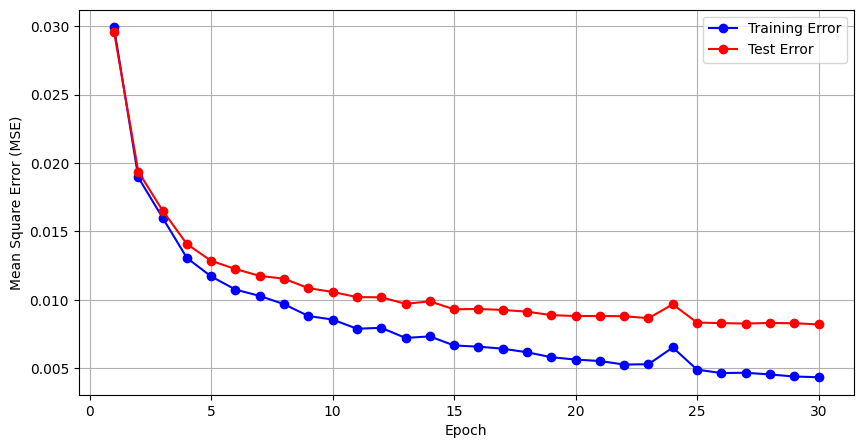

In [30]:
# 학습 및 테스트 에러 시각화하기
plt.figure(figsize=(10, 5))
plt.plot(range(1, n_epochs + 1), mse_result[0], "bo-", label="Training Error")
plt.plot(range(1, n_epochs + 1), mse_result[2], "ro-", label="Test Error")
plt.xlabel("Epoch")
plt.ylabel("Mean Square Error (MSE)")
plt.grid(True)
plt.legend()
plt.show()

### Cross Entropy 손실 함수를 사용하는 모델의 Error 변화

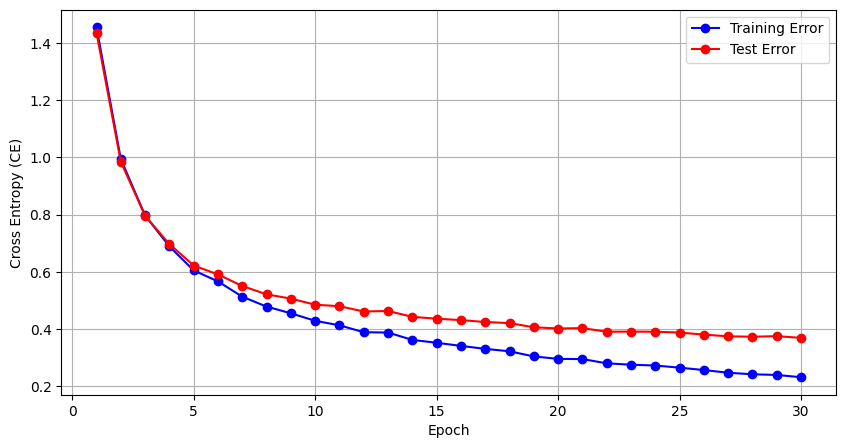

In [31]:
# 학습 및 테스트 에러 시각화하기
plt.figure(figsize=(10, 5))
plt.plot(range(1, n_epochs + 1), ce_result[0], "bo-", label="Training Error")
plt.plot(range(1, n_epochs + 1), ce_result[2], "ro-", label="Test Error")
plt.xlabel("Epoch")
plt.ylabel("Cross Entropy (CE)")
plt.grid(True)
plt.legend()
plt.show()

### 모델들의 정확도 변화

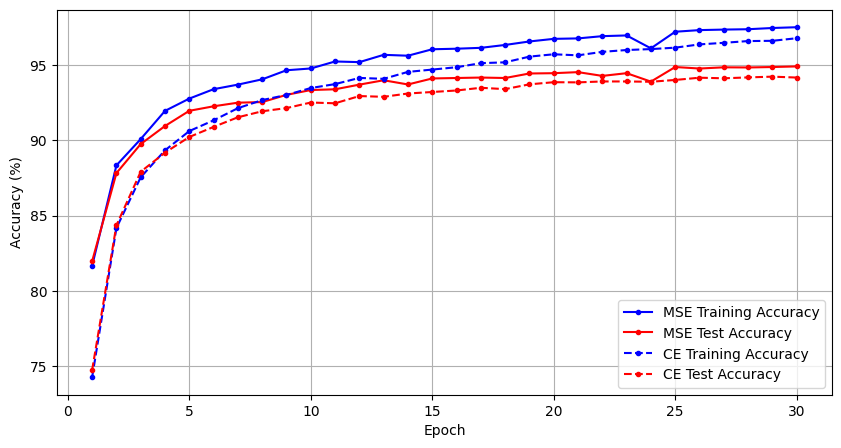

In [32]:
# 학습 및 테스트 정확도 시각화하기
plt.figure(figsize=(10, 5))
plt.plot(range(1, n_epochs + 1), mse_result[1] * 100, "b.-", label="MSE Training Accuracy")
plt.plot(range(1, n_epochs + 1), mse_result[3] * 100, "r.-", label="MSE Test Accuracy")
plt.plot(range(1, n_epochs + 1), ce_result[1] * 100, "b.--", label="CE Training Accuracy")
plt.plot(range(1, n_epochs + 1), ce_result[3] * 100, "r.--", label="CE Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.legend()
plt.show()